# Load data

In [ ]:
# Fixed GPU issue by installing nvidia driver again /opt/deeplearning/install-driver.sh
# https://askubuntu.com/questions/927199/nvidia-smi-has-failed-because-it-couldnt-communicate-with-the-nvidia-driver-ma

In [1]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/home/sidtandon/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


# Train model

In [4]:
import pickle
import os.path
import lightgbm as lgb

In [5]:
if os.path.isfile('census model.pkl'):
    print('Loading saved model')
    with open('census model.pkl', 'rb') as f:
        model = pickle.load(f)

else:
    # Setup
    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "min_data": 100,
        "boost_from_average": True
    }

    # More setup
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_val = lgb.Dataset(X_val, label=Y_val)

    # Train model
    model = lgb.train(params, d_train, 10000, valid_sets=[d_val],
                      early_stopping_rounds=50, verbose_eval=1000)
    
    # Save model
    with open('census model.pkl', 'wb') as f:
        pickle.dump(model, f)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[656]	valid_0's binary_logloss: 0.281561


# Train surrogate

In [11]:
sys.path.insert(1, '/home/sidtandon/Sid/GitRepo/fastshap')

In [2]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss

ModuleNotFoundError: No module named 'torch'

In [13]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Check for model
if os.path.isfile('census surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('census surrogate.pt').to(device)
    surrogate = Surrogate(surr, num_features)
    
else:
    # Create surrogate model
    surr = nn.Sequential(
        MaskLayer1d(value=0, append=True),
        nn.Linear(2 * num_features, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 2)).to(device)

    # Set up surrogate object
    surrogate = Surrogate(surr, num_features)

    # Set up original model
    def original_model(x):
        pred = model.predict(x.cpu().numpy())
        pred = np.stack([1 - pred, pred]).T
        return torch.tensor(pred, dtype=torch.float32, device=x.device)

    # Train
    surrogate.train_original_model(
        X_train,
        X_val,
        original_model,
        batch_size=64,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        validation_samples=10,
        validation_batch_size=10000,
        verbose=True)

    # Save surrogate
    surr.cpu()
    torch.save(surr, 'census surrogate.pt')
    surr.to(device)

----- Epoch = 1 -----
Val loss = 0.1604

New best epoch, loss = 0.1604

----- Epoch = 2 -----
Val loss = 0.1522

New best epoch, loss = 0.1522

----- Epoch = 3 -----
Val loss = 0.1449

New best epoch, loss = 0.1449

----- Epoch = 4 -----
Val loss = 0.1429

New best epoch, loss = 0.1429

----- Epoch = 5 -----
Val loss = 0.1422

New best epoch, loss = 0.1422

----- Epoch = 6 -----
Val loss = 0.1386

New best epoch, loss = 0.1386

----- Epoch = 7 -----
Val loss = 0.1377

New best epoch, loss = 0.1377

----- Epoch = 8 -----
Val loss = 0.1392

----- Epoch = 9 -----
Val loss = 0.1361

New best epoch, loss = 0.1361

----- Epoch = 10 -----
Val loss = 0.1374

----- Epoch = 11 -----
Val loss = 0.1352

New best epoch, loss = 0.1352

----- Epoch = 12 -----
Val loss = 0.1378

----- Epoch = 13 -----
Val loss = 0.1345

New best epoch, loss = 0.1345

----- Epoch = 14 -----
Val loss = 0.1354

----- Epoch = 15 -----
Val loss = 0.1355

----- Epoch = 16 -----
Val loss = 0.1339

New best epoch, loss = 0.13

# Train FastSHAP

In [17]:
from fastshap import FastSHAP

In [18]:
# Check for model
if os.path.isfile('census explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('census explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, normalization='additive',
                        link=nn.Softmax(dim=-1))

else:
    # Create explainer model
    explainer = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2 * num_features)).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, normalization='additive',
                        link=nn.Softmax(dim=-1))

    # Train
    fastshap.train(
        X_train,
        X_val[:100],
        batch_size=32,
        num_samples=32,
        max_epochs=200,
        validation_samples=128,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'census explainer.pt')
    explainer.to(device)

----- Epoch = 1 -----
Val loss = 0.077630

New best epoch, loss = 0.077630

----- Epoch = 2 -----
Val loss = 0.071694

New best epoch, loss = 0.071694

----- Epoch = 3 -----
Val loss = 0.069386

New best epoch, loss = 0.069386

----- Epoch = 4 -----
Val loss = 0.068030

New best epoch, loss = 0.068030

----- Epoch = 5 -----
Val loss = 0.066561

New best epoch, loss = 0.066561

----- Epoch = 6 -----
Val loss = 0.065571

New best epoch, loss = 0.065571

----- Epoch = 7 -----
Val loss = 0.064654

New best epoch, loss = 0.064654

----- Epoch = 8 -----
Val loss = 0.064258

New best epoch, loss = 0.064258

----- Epoch = 9 -----
Val loss = 0.064027

New best epoch, loss = 0.064027

----- Epoch = 10 -----
Val loss = 0.063670

New best epoch, loss = 0.063670

----- Epoch = 11 -----
Val loss = 0.063527

New best epoch, loss = 0.063527

----- Epoch = 12 -----
Val loss = 0.063311

New best epoch, loss = 0.063311

----- Epoch = 13 -----
Val loss = 0.063358

----- Epoch = 14 -----
Val loss = 0.06327

# Compare with KernelSHAP

In [19]:
import matplotlib.pyplot as plt

In [21]:
# Setup for KernelSHAP
def imputer(x, S):
    x = torch.tensor(x, dtype=torch.float32, device=device)
    S = torch.tensor(S, dtype=torch.float32, device=device)
    pred = surrogate(x, S).softmax(dim=-1)
    return pred.cpu().data.numpy()

In [22]:
# Select example
ind = np.random.choice(len(X_test))
x = X_test[ind:ind+1]
y = int(Y_test[ind])

# Run FastSHAP
fastshap_values = fastshap.shap_values(x)[0]

# Run KernelSHAP to convergence
game = shapreg.games.PredictionGame(imputer, x)
shap_values, all_results = shapreg.shapley.ShapleyRegression(
    game, batch_size=32, paired_sampling=False, detect_convergence=True,
    bar=True, return_all=True)

100%|██████████| 1/1 [00:02<00:00,  2.86s/it]     


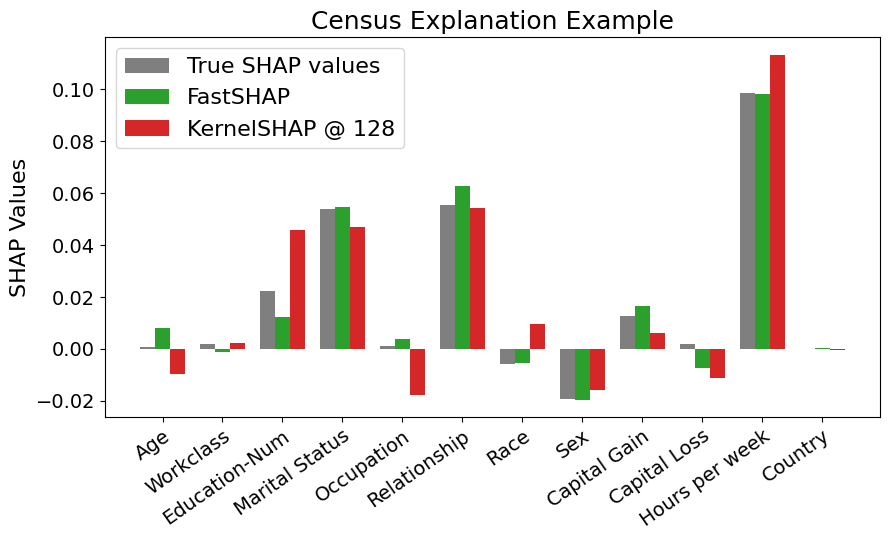

In [23]:
# Create figure
plt.figure(figsize=(9, 5.5))

# Bar chart
width = 0.75
kernelshap_iters = 128
plt.bar(np.arange(num_features) - width / 3, shap_values.values[:, y],
        width / 3, label='True SHAP values', color='tab:gray')
plt.bar(np.arange(num_features), fastshap_values[:, y],
        width / 3, label='FastSHAP', color='tab:green')
plt.bar(np.arange(num_features) + width / 3,
        all_results['values'][list(all_results['iters']).index(kernelshap_iters)][:, y],
        width / 3, label='KernelSHAP @ {}'.format(kernelshap_iters), color='tab:red')

# Annotations
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel('SHAP Values', fontsize=16)
plt.title('Census Explanation Example', fontsize=18)
plt.xticks(np.arange(num_features), feature_names,
           rotation=35, rotation_mode='anchor', ha='right')

plt.tight_layout()
plt.show()